In [109]:
#### data augmentation, according to the distribution, repeat and oscilate 
import math
import fnmatch
import datetime
import numpy as np
import xarray as xr
import pandas as pd
import os, sys, time
from glob import glob
#import tensorflow as tf

from sklearn.svm import SVC
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.svm import OneClassSVM
from sklearn.covariance import EllipticEnvelope
from sklearn.neighbors import LocalOutlierFactor
from sklearn.multiclass import OneVsRestClassifier
#from sklearn.covariance import EmpiricalCovariance, MinCovDet

import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import warnings
warnings.simplefilter(action='ignore')

In [110]:
noqa15 = pd.read_csv('out_2015_IR.csv')#, index_col=False)
noqa16 = pd.read_csv('out_2016_IR.csv')#, index_col=False)

noqa = pd.concat([noqa15, noqa16], axis = 0, ignore_index = True)

#noqa = noqa.drop(columns='Unnamed: 0')
noqa['b1'] = noqa['b1']/10000.
noqa['b2'] = noqa['b2']/10000.
noqa['sif_by_szen'] = noqa.sif/np.cos(noqa.szen)/1000
noqa['sif_by_sza'] = noqa.sif/np.cos(noqa.sza)/1000

In [118]:
choice = 'kmean' # 'kmean' or 'DBSCAN' or 'LOF' or 'robust_cov' or 'emperical_cov' or 'svm' 
# a few methods to cluster outliers out

In [119]:
#mat = noqa[['red','nir','bt3','bt5']].values
#mat = noqa[['red','b1','nir','b2']].values
mat = noqa[['red','b1','nir','b2']].values

if choice == 'kmean':
    ####### kmean    
    km = KMeans(n_clusters=2)
    #fit the model
    km.fit(mat)
    # Get cluster assignment labels
    labels = km.labels_
elif choice == 'DBSCAN':
    ####### DBSCAN
    km = DBSCAN(eps=1, min_samples=100)   
    km.fit(mat)
    labels = km.labels_
    # eps: The maximum distance between two samples for one to be considered as in the neighborhood of the other. 
    # min_samples: The number of samples (or total weight) in a neighborhood for a point to be considered as a core point.
elif choice == 'robust_cov':
    labels = EllipticEnvelope(contamination=0.1).fit_predict(mat)  ##0.1
    # assume_centered = True
elif choice == 'svm':
    labels = OneClassSVM(nu=0.1, gamma='auto').fit_predict(mat)
######### this is a bad method to me
elif choice == 'LOF':   
    ####### LocalOutlierFactor
    km = LocalOutlierFactor(n_neighbors=1000, contamination='auto') 
    # n_neighborsint Number of neighbors to use by default for kneighbors queries.
    labels = km.fit_predict(mat)
    
######### this is supervised I guess because you need a y
# elif choice == 'onevsrest':
#     OneVsRestClassifier(SVC()).fit(X, y)

######### did not find function or not directly appliable
# elif choice == 'robust_pca':
#     # remember, after using pca you still need to apply another classifier
#     # but maybe robust pca works ?

In [121]:
# Format results as a DataFrame
label_results = pd.DataFrame([noqa.index,labels]).T

if choice in ['DBSCAN']:
    label_results[label_results[1]==0] = 1
    label_results[label_results[1]==-1] = 0
    # DBSCAN has the label 0 and -1, we only use 0 and 1 as the label
elif choice in ['LOF','robust_cov','svm']:
    label_results[label_results[1]==-1] = 0

np.unique(label_results[1])

array([0, 1])

In [122]:
noqa['label'] = label_results[1]
print(len(noqa[noqa.label==1]),np.unique(label_results[1]))

38861 [0 1]


In [123]:
x = np.linspace(0,1,100)
y = x

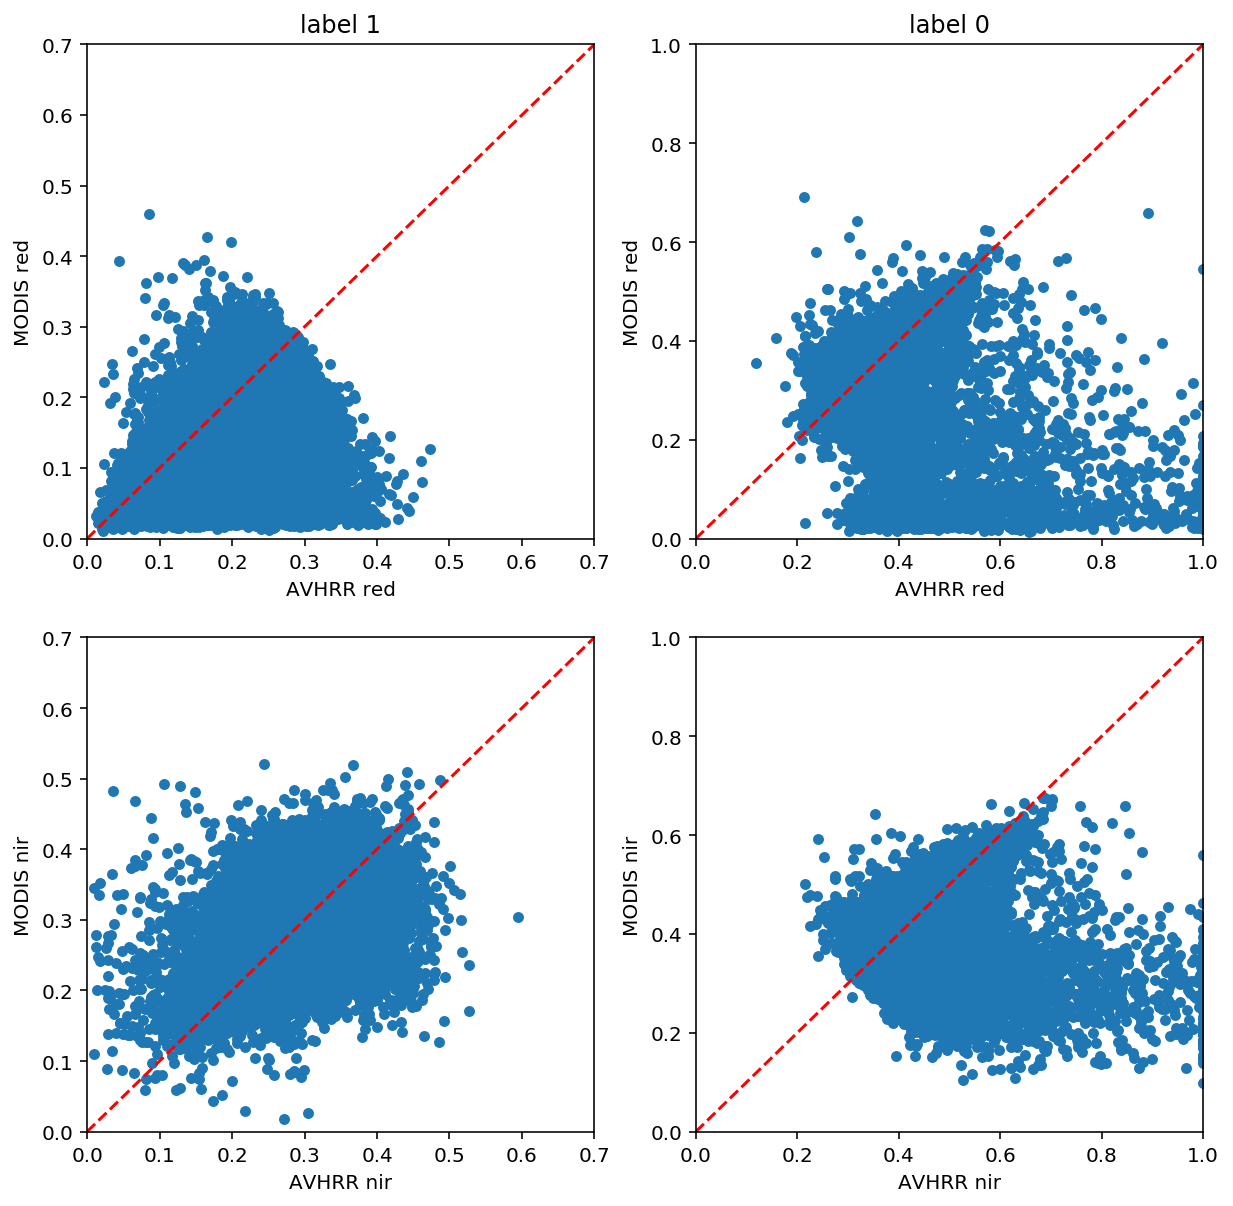

In [124]:
fig, ax = plt.subplots(ncols = 2, nrows = 2, figsize = (10,10))
noqa[noqa.label==1].plot(ax = ax[0][0], kind='scatter',x='red',y='b1')
ax[0][0].plot(x,y,'--',color='r')
ax[0][0].set_xlim([0,0.7])
ax[0][0].set_ylim([0,0.7])
ax[0][0].set_title('label 1')
ax[0][0].set_xlabel('AVHRR red')
ax[0][0].set_ylabel('MODIS red')


noqa[noqa.label==0].plot(ax = ax[0][1],kind='scatter',x='red',y='b1')
ax[0][1].plot(x,y,'--',color='r')
ax[0][1].set_xlim([0,1])
ax[0][1].set_ylim([0,1])
ax[0][1].set_title('label 0')
ax[0][1].set_xlabel('AVHRR red')
ax[0][1].set_ylabel('MODIS red')
#len(noqa[noqa.label==0])

noqa[noqa.label==1].plot(ax = ax[1][0], kind='scatter',x='nir',y='b2')
ax[1][0].plot(x,y,'--',color='r')
ax[1][0].set_xlim([0,0.7])
ax[1][0].set_ylim([0,0.7])
ax[1][0].set_xlabel('AVHRR nir')
ax[1][0].set_ylabel('MODIS nir')
#ax[1][0].set_title('label 1')
#len(noqa[noqa.label==0])

noqa[noqa.label==0].plot(ax = ax[1][1],kind='scatter',x='nir',y='b2')
ax[1][1].plot(x,y,'--',color='r')
ax[1][1].set_xlim([0,1])
ax[1][1].set_ylim([0,1])
ax[1][1].set_xlabel('AVHRR nir')
ax[1][1].set_ylabel('MODIS nir')
#ax[1][1].set_title('label 0')
#len(noqa[noqa.label==0])

#fig.suptitle('Robust Covariance Outlier Detection', fontsize=13, fontweight='bold', y=0.93)

plt.rcParams['savefig.dpi'] = 220
plt.savefig('kmean_modis_avhrr_red_nir.png')
#plt.savefig('robust_modis_avhrr_red_nir.png')

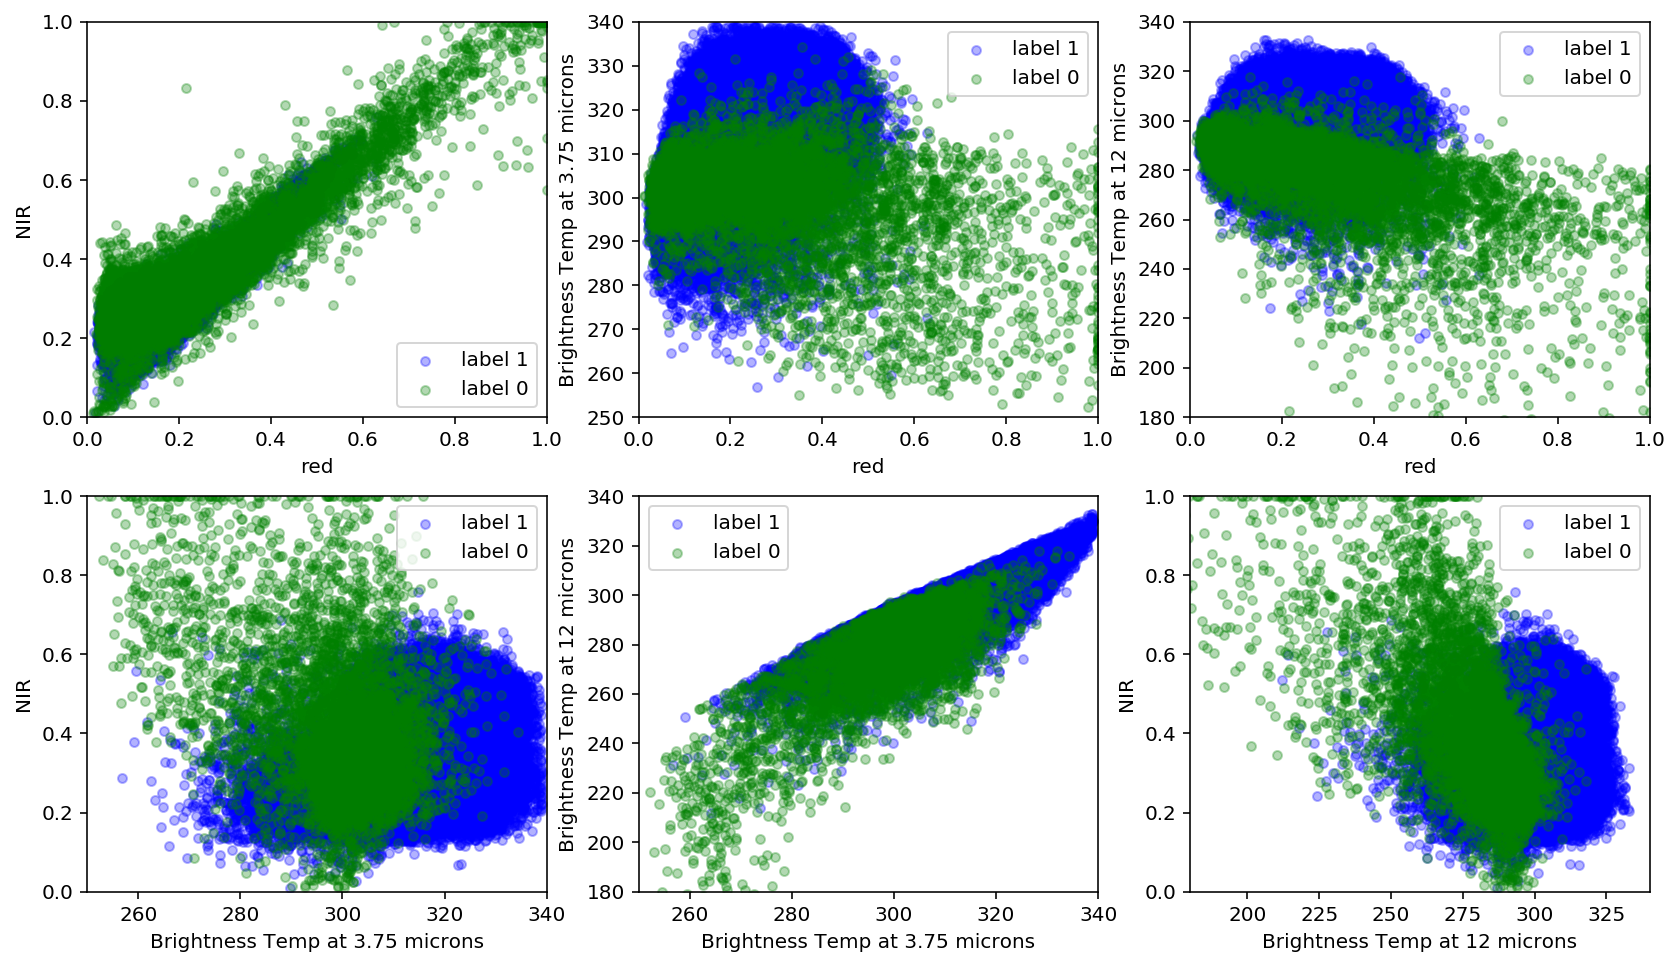

In [106]:
fig, ax = plt.subplots(ncols = 3, nrows = 2, figsize = (14,8))
noqa[noqa.label==1].plot(ax = ax[0][0], kind='scatter',x='red',y='nir', c='blue',alpha=.3,label='label 1')
noqa[noqa.label==0].plot(ax = ax[0][0], kind='scatter',x='red',y='nir', c='green',alpha=.3, label='label 0')
ax[0][0].set_xlim([0,1])
ax[0][0].set_ylim([0,1])
ax[0][0].set_xlabel('red')
ax[0][0].set_ylabel('NIR')

noqa[noqa.label==1].plot(ax = ax[0][1], kind='scatter',x='red',y='bt3',c='blue',alpha=.3,label='label 1')
noqa[noqa.label==0].plot(ax = ax[0][1], kind='scatter',x='red',y='bt3', c='green',alpha=.3,label='label 0')

ax[0][1].set_xlim([0,1])
ax[0][1].set_ylim([250,340])
ax[0][1].set_xlabel('red')
ax[0][1].set_ylabel('Brightness Temp at 3.75 microns')
#len(noqa[noqa.label==0])

noqa[noqa.label==1].plot(ax = ax[0][2], kind='scatter',x='red',y='bt5',c='blue',alpha=.3,label='label 1')
noqa[noqa.label==0].plot(ax = ax[0][2], kind='scatter',x='red',y='bt5',c='green',alpha=.3,label='label 0')
ax[0][2].set_xlim([0,1])
ax[0][2].set_ylim([180,340])
ax[0][2].set_xlabel('red')
ax[0][2].set_ylabel('Brightness Temp at 12 microns')
#len(noqa[noqa.label==0])

noqa[noqa.label==1].plot(ax = ax[1][0], kind='scatter',x='bt3',y='nir',c='blue',alpha=.3,label='label 1')
noqa[noqa.label==0].plot(ax = ax[1][0], kind='scatter',x='bt3',y='nir',c='green',alpha=.3,label='label 0')
ax[1][0].set_ylim([0,1])
ax[1][0].set_xlim([250,340])
ax[1][0].set_xlabel('Brightness Temp at 3.75 microns')
ax[1][0].set_ylabel('NIR')

noqa[noqa.label==1].plot(ax = ax[1][1], kind='scatter',x='bt3',y='bt5',c='blue',alpha=.3,label='label 1')
noqa[noqa.label==0].plot(ax = ax[1][1], kind='scatter',x='bt3',y='bt5',c='green',alpha=.3,label='label 0')
ax[1][1].set_xlim([250,340])
ax[1][1].set_ylim([180,340])
ax[1][1].set_xlabel('Brightness Temp at 3.75 microns')
ax[1][1].set_ylabel('Brightness Temp at 12 microns')

noqa[noqa.label==1].plot(ax = ax[1][2], kind='scatter',x='bt5',y='nir',c='blue',alpha=.3,label='label 1')
noqa[noqa.label==0].plot(ax = ax[1][2], kind='scatter',x='bt5',y='nir',c='green',alpha=.3,label='label 0')
ax[1][2].set_ylim([0,1])
ax[1][2].set_xlim([180,340])
ax[1][2].set_xlabel('Brightness Temp at 12 microns')
ax[1][2].set_ylabel('NIR')

plt.legend()
plt.show()

plt.rcParams['savefig.dpi'] = 220
#plt.savefig('robust_modis_avhrr_red_nir_showavhrr.png')

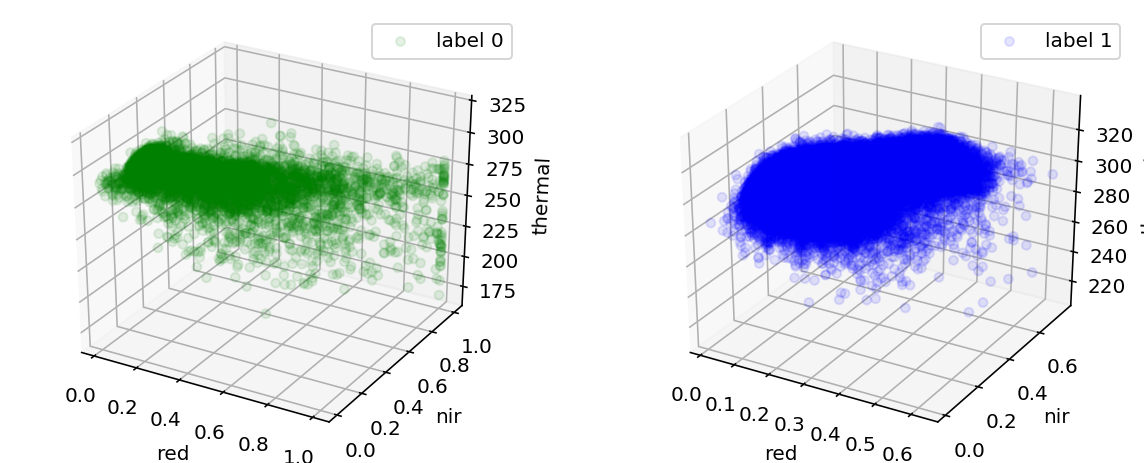

In [108]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

fig = plt.figure(figsize = (10,4))

ax = fig.add_subplot(121, projection='3d')

ax.set_xlabel('red')
ax.set_ylabel('nir')
ax.set_zlabel('thermal')

x = noqa[noqa.label==0].red
y = noqa[noqa.label==0].nir
z = noqa[noqa.label==0].bt5
ax.scatter(x, y, z, marker='o', color='green', alpha = 0.1, label='label 0')
plt.legend()

#ax.scatter(x, y, z, marker='o', color='blue', alpha = 0.1, label='label 1')

ax2 = fig.add_subplot(122, projection='3d')
x = noqa[noqa.label==1].red
y = noqa[noqa.label==1].nir
z = noqa[noqa.label==1].bt5
ax2.set_xlabel('red')
ax2.set_ylabel('nir')
ax2.set_zlabel('thermal')
ax2.scatter(x, y, z, marker='o', color='blue', alpha = 0.1, label='label 1')
plt.legend()
plt.show()